In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier, export_text
from custom_decision_tree import SemanticDecisionTree, print_tree, plot_tree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def create_synthetic_data(n_samples=1000, random_state=42, multiclass=False):
    rng = np.random.default_rng(random_state)

    special_features = {
        "special_feature_1": {
            "valid_range": (0, 90),
            "special_values": [97, 98, 99]
        },
        "special_feature_2": {
            "valid_range": (0, 990),
            "special_values": [996, 997, 998, 999]
        },
        "special_feature_3": {
            "valid_range": (0, 9990),
            "special_values": [9997, 9998, 9999]
        },
        "special_feature_4": {
            "valid_range": (0, 99990),
            "special_values": [99996, 99997, 99998, 99999]
        },
        "special_feature_5": {
            "valid_range": (0, 999990),
            "special_values": [999998, 999999]
        },
        "special_feature_6": {
            "valid_range": (0, 999999990),
            "special_values": [999999998, 999999999]
        }
    }
    
    X_data = ({
        "feature_1": [],
        "feature_2": [],
        "feature_3": [],
        "feature_4": [],
        "feature_5": [],
        "feature_6": []
    })
    
    X_data.update({feature: [] for feature in special_features})

    for _ in range(n_samples):
        row = {}

        for feature, config in special_features.items():
            use_special = rng.random() < 0.20
            if use_special:
                value = rng.choice(config["special_values"])
                row[feature] = value
            else:
                value = rng.integers(0, config["valid_range"][1] * 0.15)
                row[feature] = value

        feature_1 = round(rng.normal(550, 100), 3)
        feature_2 = round(rng.uniform(0.2, 0.9), 3)
        feature_3 = round(rng.uniform(0.2, 0.9), 3)
        feature_4 = round(rng.uniform(1000, 10000), 3)
        feature_5 = rng.integers(0, 2)
        feature_6 = rng.integers(0, 2)

        row.update({
            "feature_1": np.clip(feature_1, 330, 750),
            "feature_2": feature_2,
            "feature_3": feature_3,
            "feature_4": feature_4,
            "feature_5": feature_5,
            "feature_6": feature_6
        })

        for k, v in row.items():
            X_data[k].append(v)

    df = pd.DataFrame(X_data)

    def assign_multiclass_label(row):
        special_count = sum(
            str(row[f]).split('.')[0] in map(str, special_features[f]["special_values"])
            for f in special_features
        )

        if (row["feature_1"] < 480) or (special_count >= 4):
            return 2
        elif (row["feature_1"] < 600) or (row["feature_2"] + row["feature_3"] > 1.4):
            return 1
        else:
            return 0
    
    def assign_binary_label(row):
        special_count = sum(
            str(row[f]).split('.')[0] in map(str, special_features[f]["special_values"])
            for f in special_features
        )

        if ((row["feature_1"] < 480) and ((row["feature_2"] + row["feature_3"]) > 0.8)) or (special_count >= 3):
            return 1 
        else:
            return 0

    if multiclass:
        df["label"] = df.apply(assign_multiclass_label, axis=1)
    else:
        df["label"] = df.apply(assign_binary_label, axis=1)

    return df

In [21]:
simple_test_data = [
    [1000.52, 25],
    [999999, 45],
    [5000, 30],
    [999998, 40],
    [3000, 35],
    [200000, 60],
    [300000, 70],
    [999998, 39],
    [999999, 43],
    [999997, 46],
    [999999, 41],
    [999997, 42]
]

labels = ['2', '0', '3', '4', '2', '5', '5', '4', '0', '0', '0', '0']

special_values_list = {
    "feature_0": {
        "description": "test",
        "special_values": {
            "999997": "test 1",
            "999998": "test 2",
            "999999": "test 3"
        }
    }
}

X = np.array(simple_test_data)
y = np.array(labels)

In [22]:
semantic_test_tree = SemanticDecisionTree(max_depth=5, special_values_json=special_values_list)
semantic_test_tree.fit(X, y)
print("Predictions:", semantic_test_tree.predict(X))
print_tree(semantic_test_tree)

Predictions: ['2' '0' '3' '4' '2' '5' '5' '4' '0' '0' '0' '0']
|--- [Numerical] feature_1 <= 40.4 
|   |--- [Numerical] feature_0 <= 3000.0 
|   |   |--- Predict: 2 
|   |--- [Numerical] feature_0 >  3000.0 
|   |   |--- [Categorical] feature_0 != 999998.0 
|   |   |   |--- Predict: 3 
|   |   |--- [Categorical] feature_0 == 999998.0 
|   |   |   |--- Predict: 4 
|--- [Numerical] feature_1 >  40.4 
|   |--- [Numerical] feature_1 <= 48.8 
|   |   |--- Predict: 0 
|   |--- [Numerical] feature_1 >  48.8 
|   |   |--- Predict: 5 


In [23]:
sklearn_test_tree = DecisionTreeClassifier(random_state=42)
sklearn_test_tree.fit(X, y)
print("Predictions:", sklearn_test_tree.predict(X))
print(export_text(sklearn_test_tree))

Predictions: ['2' '0' '3' '4' '2' '5' '5' '4' '0' '0' '0' '0']
|--- feature_0 <= 649998.50
|   |--- feature_1 <= 47.50
|   |   |--- feature_0 <= 4000.00
|   |   |   |--- class: 2
|   |   |--- feature_0 >  4000.00
|   |   |   |--- class: 3
|   |--- feature_1 >  47.50
|   |   |--- class: 5
|--- feature_0 >  649998.50
|   |--- feature_1 <= 40.50
|   |   |--- class: 4
|   |--- feature_1 >  40.50
|   |   |--- class: 0



In [24]:
df = create_synthetic_data(n_samples=10000, random_state=42, multiclass=False)

In [25]:
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,special_feature_1,special_feature_2,special_feature_3,special_feature_4,special_feature_5,special_feature_6,label
0,464.696,0.460,0.849,6794.786,0,1,8,64,301,1412,107620,999999999,1
1,534.547,0.745,0.336,5200.489,0,0,5,33,9999,12412,105077,53178894,0
2,465.984,0.359,0.669,4934.367,0,1,99,101,615,4886,119350,999999998,1
3,556.758,0.751,0.665,7346.488,0,1,1,46,1260,5811,95513,999999998,0
4,608.622,0.591,0.413,1277.361,0,0,6,998,9998,10024,11879,114749827,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,484.899,0.237,0.765,6545.597,1,0,99,127,9997,11808,68171,94650217,0
9996,533.357,0.390,0.683,2981.676,0,1,8,138,9998,7335,999998,999999998,1
9997,558.967,0.285,0.352,6858.187,1,1,11,24,1098,8305,999998,117391137,0
9998,513.617,0.621,0.609,6692.831,1,1,4,132,9999,4396,87916,83883432,0


In [26]:
special_values_list = {
    "special_feature_1": {
        "description": "special_feature_1 test description",
        "special_values": {
            "97": "97 description",
            "98": "98 description",
            "99": "99 description"
        }
    },
    "special_feature_2": {
        "description": "special_feature_2 test description",
        "special_values": {
            "996": "996 description",
            "997": "997 description",
            "998": "998 description",
            "999": "999 description"
        }
    },
    "special_feature_3": {
        "description": "special_feature_3 test description",
        "special_values": {
            "9997": "9997 description",
            "9998": "9998 description",
            "9999": "9999 description"
        }
    },
    "special_feature_4": {
        "description": "special_feature_4 test description",
        "special_values": {
            "99996": "99996 description",
            "99997": "99997 description",
            "99998": "99998 description",
            "99999": "99999 description"
        }
    },
    "special_feature_5": {
        "description": "special_feature_5 test description",
        "special_values": {
            "999998": "999998 description",
            "999999": "999999 description"
        }
    },
    "special_feature_6": {
        "description": "special_feature_6 test description",
        "special_values": {
            "999999998": "999999998 description",
            "999999999": "999999999 description"
        }
    }
}
    

In [27]:
X = df.drop(columns='label')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
semantic_tree = SemanticDecisionTree(max_depth=5, special_values_json=special_values_list, random_state=42)
semantic_tree.fit(X_train, y_train)
semantic_y_pred = semantic_tree.predict(X_test)

In [29]:
print(classification_report(y_test, semantic_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1437
           1       0.85      0.71      0.77       563

    accuracy                           0.88      2000
   macro avg       0.87      0.83      0.85      2000
weighted avg       0.88      0.88      0.88      2000



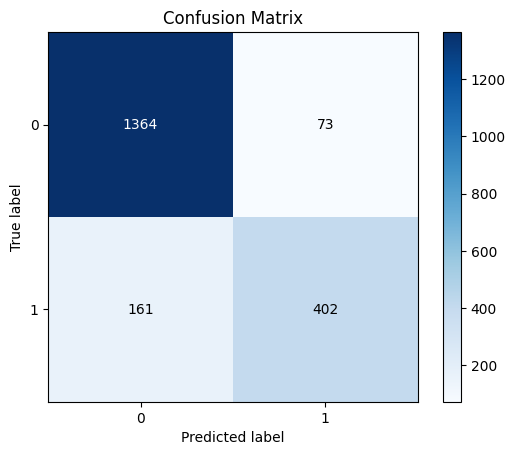

In [30]:
skplt.metrics.plot_confusion_matrix(y_test, semantic_y_pred)
plt.show()

In [31]:
print_tree(semantic_tree)

|--- [Numerical] feature_1 <= 494.801 
|   |--- [Numerical] feature_1 <= 478.06 
|   |   |--- Predict: 1.0 
|   |--- [Numerical] feature_1 >  478.06 
|   |   |--- [Numerical] feature_1 <= 479.804 
|   |   |   |--- Predict: 1.0 
|   |   |--- [Numerical] feature_1 >  479.804 
|   |   |   |--- Predict: 0.0 
|--- [Numerical] feature_1 >  494.801 
|   |--- Predict: 0.0 


In [32]:
sklearn_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
sklearn_tree.fit(X_train, y_train)
sklearn_y_pred = sklearn_tree.predict(X_test)

In [33]:
print(classification_report(y_test, sklearn_y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1437
           1       0.99      0.78      0.87       563

    accuracy                           0.94      2000
   macro avg       0.96      0.89      0.91      2000
weighted avg       0.94      0.94      0.93      2000



In [34]:
print(export_text(sklearn_tree))

|--- feature_0 <= 479.99
|   |--- feature_2 <= 0.46
|   |   |--- feature_1 <= 0.48
|   |   |   |--- feature_2 <= 0.39
|   |   |   |   |--- feature_9 <= 57388.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_9 >  57388.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  0.39
|   |   |   |   |--- feature_1 <= 0.38
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1 >  0.38
|   |   |   |   |   |--- class: 1
|   |   |--- feature_1 >  0.48
|   |   |   |--- feature_1 <= 0.55
|   |   |   |   |--- feature_2 <= 0.28
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_2 >  0.28
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_1 >  0.55
|   |   |   |   |--- feature_1 <= 0.57
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_1 >  0.57
|   |   |   |   |   |--- class: 1
|   |--- feature_2 >  0.46
|   |   |--- feature_1 <= 0.26
|   |   |   |--- feature_2 <= 0.60
|   |   |   |   |--- feature_7 <= 124.50
|   |   |   |   |   

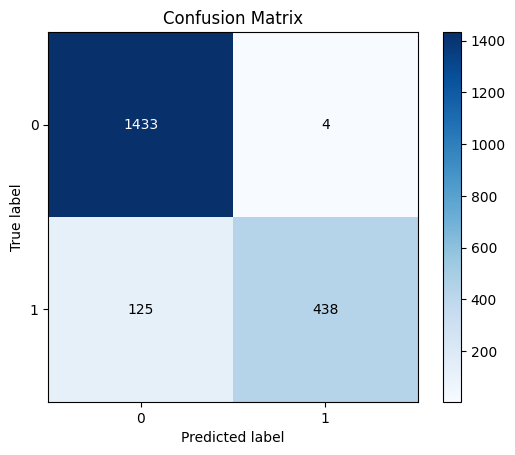

In [35]:
skplt.metrics.plot_confusion_matrix(y_test, sklearn_y_pred)
plt.show()

In [36]:
# dot = plot_tree(tree)
# dot.render('decision_tree', format='png', view=True)